# airbnKEY

## Project Description
Home affordability continues to be a major challenge in many metropolitan areas.  With housing prices continuing to outpace wage growth, it has become increasingly difficult for prospective home buyers to fulfill the American dream.

Fortunately, homeowners now have the option to Airbnb spare rooms in their new homes to help pay for the mortgage.  

This project aims to estimate the dollar benefit a homeowner can expect from a given home.

### Confidentiality Note:
This analysis was conducted in collaboration with Loftium, Inc (http://www.loftium.com/). Due to the confidentiality of the data and modeling process, only a subset of the analysis is shown here. 

# Modeling Walkthrough

This Jupyter Notebook walks through the data preparation, modeling, evaluation, and interpretation methodologies used in this project. 

In [1]:
import pandas as pd
import numpy as np
from pandas import scatter_matrix
from collections import defaultdict
import json
import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import cPickle as pickle

In [2]:
# Helper modules
import src.airbnb_EDA_helper as eda
import src.airbnb_prediction_helper as pred
import src.airbnb_read_data_helper as read
import src.airbnKEY_model as key

/Users/johnkim/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/johnkim/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
#import sklearn modules
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import clone

In [4]:
pd.set_option('display.max_columns', None)

## Loading Data

In [5]:
listing_data_raw_df = pd.read_excel('data/Loftium/Back testing - Copy.xlsx', sheetname='Listings')
listing_data_raw_df.columns = listing_data_raw_df.columns.str.replace(' ','_').str.replace('\(','').str.replace('\)','').str.replace('-','')  

In [6]:
listing_full_data_df = listing_data_raw_df.copy()
listing_full_data_df.Listing_Title = listing_data_raw_df.Listing_Title.str.lower()

### Cleaning Data

Tha data has a significant number of null and missing values. 

Let's clean up the null values with appropriate imputation methods. 

In [7]:
null_cols = eda.check_for_null(listing_full_data_df)

***WARNING*** : 1 null values in Host_ID
***WARNING*** : 209 null values in Neighborhood
***WARNING*** : 157 null values in Overall_Rating
***WARNING*** : 5 null values in Bathrooms
***WARNING*** : 4 null values in Calendar_Last_Updated
***WARNING*** : 299 null values in Response_Rate
***WARNING*** : 300 null values in Response_Time_min
***WARNING*** : 241 null values in Superhost
***WARNING*** : 1218 null values in Security_Deposit
***WARNING*** : 614 null values in Cleaning_Fee
***WARNING*** : 1062 null values in Extra_People_Fee
***WARNING*** : 3 null values in Published_Monthly_Rate
***WARNING*** : 4 null values in Published_Weekly_Rate
***WARNING*** : 650 null values in Checkin_Time
***WARNING*** : 636 null values in Checkout_Time


In [8]:
listing_full_data_df = eda.impute_null_columns(listing_full_data_df)

# Confirming that all null values have been removed
eda.check_for_null(listing_full_data_df)

[]

In [9]:
# Adding flags for views, water, priv bathrooms, parking, nonrooms
listing_full_data_df['view'] = listing_full_data_df.Listing_Title.str.contains(' view').astype(int)
water_pattern = r'(( water|^water|saltwater| lake|^lake|greenlake| bay|^bay).*(view))|(view).*( water|^water|saltwater| lake|^lake|greenlake| bay|^bay)';
listing_full_data_df['water'] = listing_full_data_df.Listing_Title.str.contains(water_pattern).astype(int);
listing_full_data_df['private_bath'] = listing_full_data_df.Listing_Title.str.contains('bath').astype(int)
listing_full_data_df['walk'] = (listing_full_data_df.Listing_Title.str.contains('walk')).astype(int)
listing_full_data_df['parking'] = (listing_full_data_df.Listing_Title.str.contains('parking')).astype(int)
nonroom_pattern = r'((couch|futon|space))';
listing_full_data_df['nonroom'] = ((listing_full_data_df.Listing_Title.str.contains(nonroom_pattern)) & \
                          ~(listing_full_data_df.Listing_Title.str.contains('needle'))).astype(int);

# Converting Created_Date to Days_Since_Created
listing_full_data_df['Days_Since_Created'] = listing_full_data_df.Created_Date.apply(lambda x: (listing_full_data_df.Created_Date.max()-x).days)

# Only keeping relevant property types
listing_full_data_df['Property_Type'].replace('Bed &amp; Breakfast', 'Bed & Breakfast', inplace=True)
features_Property_type_keep = ['House', 'Apartment','Townhouse','Condominium', 'Bed & Breakfast','Loft','Other']
listing_full_data_df = listing_full_data_df[listing_full_data_df.Property_Type.isin(features_Property_type_keep)]

# Given Pike-Market's clear impact on EDR, include as a flag
listing_full_data_df['Pike_Market'] = (listing_full_data_df.Neighborhood=='Pike-Market').astype(int)

/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


### Creating the target column

In [10]:
listing_full_data_df['EDR'] = listing_full_data_df.Occupancy_Calculated * listing_full_data_df.Average_Daily_Rate

### Removing data points that are not representative of our user base

A key assumption is that our prospective homeowners are seeking to *maximize* the value capture of their spare rooms.  We do not want the data generated by passive hosts to influence our model training process. Thus, we will only be including data for hosts/properties with meaningful occupancy rates.

In [11]:
listing_data_df = listing_full_data_df[listing_full_data_df.Number_of_Bookings_LTM > 4]
listing_data_df = listing_full_data_df[listing_full_data_df.Occupancy_Calculated > .5]

In [12]:
listing_data_df.shape

(974, 55)

# Predictive Modeling (Annual)

Now that our data and feature space is ready, let's begin the modeling process.

We will be using an incremental modeling process, first starting with a very simple model.  For each successive iteration, we will build in more complexity and evaluate the improvement in scoring to see if the added complexity helps our predictive power.

Our model of choice will be gradient boosting regression.  Gradient boosting is widely known as one of the more powerful algorithms.  Its ability to handle non-linear relationships and interaction effects make it a very attractive choice for this project. 

Our target variable is **Expected Daily Rate (EDR)**, which is the expected amount of money one is expected to earn on a single day. 

## GDBR Iteration 0
For iteration 0, let's look at a very basic model that tries to predict EDR based only on location (latitude and longitude)
- GDBR0 - Only Latitude and Longitude


### Feature Engineering

In [13]:
listing_gdbr0_cols_keep = [
    'EDR', 
    # ==== LOCATION ================
    'Latitude', 'Longitude'
]

listing_gdbr0_cols_dummy = []

### Train Test Split

Building training and test sets for designated feature space above

In [14]:
listing_gdbr0_dummy_dfs = key.get_dummy_dfs(listing_data_df, listing_gdbr0_cols_dummy)
X = key.prep_model_df(listing_data_df, listing_gdbr0_cols_keep, listing_gdbr0_dummy_dfs)
y = X.pop('EDR')
X_train, X_test, y_train, y_test = train_test_split(X,y)

### Model Evaluation
Let's use cross validation to simulate the model's performance on unseen data. 

Here, we are plotting cross validation error against number of boosting stages (i.e., the number of decision trees) to ascertain the optimal number of trees. 

Optimal point: 2494 trees, MSE 298.372172492


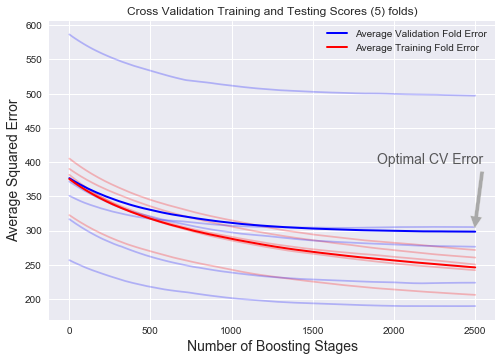

In [15]:
optimal_n_trees, learning_rate = pred.plot_cross_validation_train_and_test(GradientBoostingRegressor(learning_rate=0.001), 
                                                            X_train, y_train)

The plot above shows cross validation results for 5 K-folds. It's worth noting that for this very basic model, there is quite a bit of model variation across each CV run.  

These results suggest that this basic model is not sufficient for predicting EDR. We will need to do some more feature engineering to improve results! 

### Bootstrap sampling

Cross Validation is a technique to validate the performance of a “Model” to make sure that we are not overfitting the training dataset. It involves splitting the training data-set and training and testing on different parts of the dataset

Bootstrap is a complementary method that can be used to estimate variance of a parameter / estimate. It is a way of simulating the distribution of the model score on unseen data. 

Here, we are bootstrapping with replacement, and then making predictions on the out-of-bag data points.  The resulting out-of-bag error is an estimate of the model performance.  By running hundreds of bootstrap samples through our model, we can get a sense of the distribution of the modeling error. 

In [16]:
gdbr0_mse_scores = pred.get_bootstrap_mse_score_dist(GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=optimal_n_trees), 
                                                     X, y, num_bootstrap=500)

Running iteration 0 ...
Running iteration 100 ...
Mean of mse_scores =  291.498132474
Running iteration 200 ...
Mean of mse_scores =  294.337461033
Running iteration 300 ...
Mean of mse_scores =  293.567750966
Running iteration 400 ...
Mean of mse_scores =  295.586028086
Mean MSE: 294.825463778


0 MSE: 294.825463778


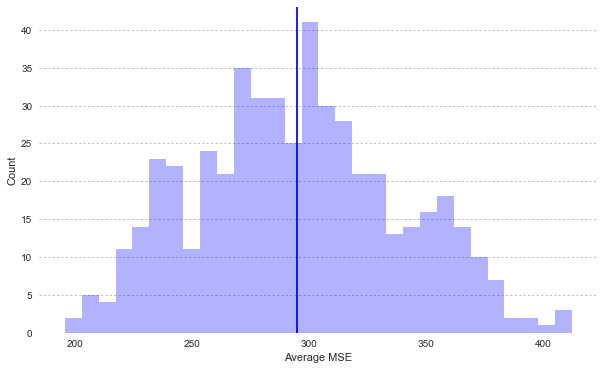

In [17]:
mse_score_lists = [gdbr0_mse_scores]
colors=['blue']
pred.plot_mse_distribution(mse_score_lists,colors)

### Model Evaluation
The above histogram shows the distribution of mean-squared error for our basic model (GDBR0) that generated by using bootstrapping. The mean MSE is 303.5. 

Let's try to improve on this with our next iteration.

# GDBR Iteration 1
In iteration 0, we evaluated a very basic model that only considered location, yielding less than satisfactory results.

For our next iteration, let's see what happens if we also put in features for "host quality". 

- GDBR0 - Only Latitude and Longitude
- GDBR1 - Adding in host quality features

In [18]:
listing_gdbr1_cols_keep = [
'EDR', 

# ==== LOCATION ================  GDBR0
'Latitude', 'Longitude',

# ==== HOST QUALITY ============  GDBR1
'Superhost', 'Overall_Rating','Number_of_Reviews', 
]

listing_gdbr1_cols_dummy = []

In [19]:
listing_gdbr1_dummy_dfs = key.get_dummy_dfs(listing_data_df, listing_gdbr1_cols_dummy)
X = pred.prep_model_df(listing_data_df, listing_gdbr1_cols_keep, listing_gdbr1_dummy_dfs)
y = X.pop('EDR')
X_train, X_test, y_train, y_test = train_test_split(X,y)

Optimal point: 1473 trees, MSE 248.81626674


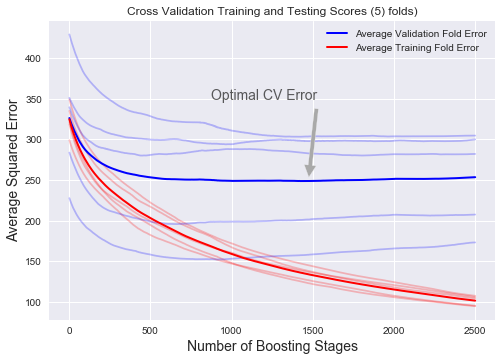

In [20]:
optimal_n_trees, learning_rate = pred.plot_cross_validation_train_and_test(GradientBoostingRegressor(learning_rate=0.005), 
                                                            X_train, y_train)

In [21]:
gdbr1_mse_scores = pred.get_bootstrap_mse_score_dist(GradientBoostingRegressor(learning_rate=learning_rate, 
                                                                               n_estimators=optimal_n_trees), 
                                                     X, y, num_bootstrap=500)

Running iteration 0 ...
Running iteration 100 ...
Mean of mse_scores =  293.463540703
Running iteration 200 ...
Mean of mse_scores =  294.038277676
Running iteration 300 ...
Mean of mse_scores =  292.478624886
Running iteration 400 ...
Mean of mse_scores =  292.04803065
Mean MSE: 291.318488401


0 MSE: 294.825463778
1 MSE: 291.318488401


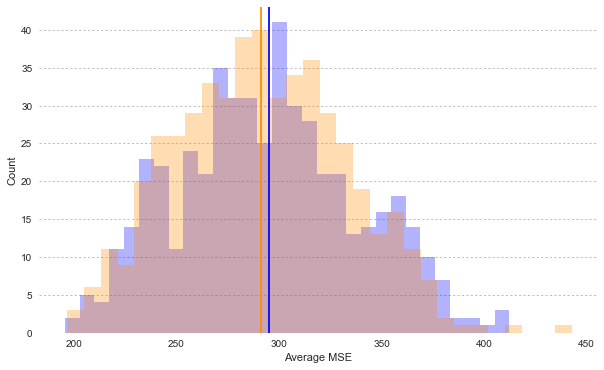

In [22]:
mse_score_lists = [gdbr0_mse_scores, gdbr1_mse_scores]
colors=['blue', 'darkorange']
pred.plot_mse_distribution(mse_score_lists,colors)

### Model Evaluation
The above histogram now shows the bootstrapped distribution of mean-squared error for our basic model (GDBR0, blue) and our "improved" model with features that describe host quality (GDBR1, orange).  

The improvement is modest, but worthy of the effort. 

The results give us some confidence that host quality improves our modeling performance, so we will keep those features moving forward.

Let's continue iterating by adding additional features that might improve performance.

# GDBR Iteration 2
For this iteration, we'll add in several features for listing details, special features, and property type dummy.

For additional context on how the special features (view, private bathroom) were ascertained, see the Natural Language Processing Jupyter Notebook walkthrough. 

- GDBR0 - Only Latitude and Longitude
- GDBR1 - Adding in features for host quality
- GDBR2 - Adding in features for listing details, special features, and property type (dummy)

In [23]:
listing_gdbr2_cols_keep = [
    'EDR', 

    # ==== LOCATION ================
    'Latitude', 'Longitude',

    # ==== HOST QUALITY ============
    'Superhost', 'Overall_Rating','Number_of_Reviews',  

    # ==== LISTING DETAILS ==========a
    'Days_Since_Created', 'Instantbook_Enabled',

    # ==== SPECIAL FEATURES ========
    'private_bath', 'view',
]

listing_gdbr2_cols_dummy = [
    'Property_Type'    
]

In [24]:
listing_gdbr2_dummy_dfs = key.get_dummy_dfs(listing_data_df, listing_gdbr2_cols_dummy)
X = pred.prep_model_df(listing_data_df, listing_gdbr2_cols_keep, listing_gdbr2_dummy_dfs)
y = X.pop('EDR')
X_train, X_test, y_train, y_test = train_test_split(X,y)

Optimal point: 906 trees, MSE 271.666397873


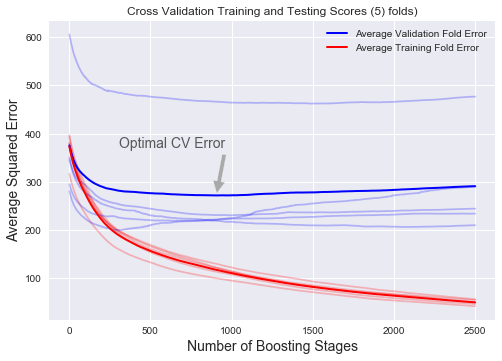

In [25]:
optimal_n_trees, learning_rate = pred.plot_cross_validation_train_and_test(GradientBoostingRegressor(learning_rate=0.01), 
                                                                           X_train, y_train)

In [26]:
gdbr2_mse_scores = pred.get_bootstrap_mse_score_dist(GradientBoostingRegressor(learning_rate=learning_rate, 
                                                                               n_estimators=optimal_n_trees), 
                                                     X, y, num_bootstrap=500)

Running iteration 0 ...
Running iteration 100 ...
Mean of mse_scores =  278.411449545
Running iteration 200 ...
Mean of mse_scores =  278.427086757
Running iteration 300 ...
Mean of mse_scores =  278.822712036
Running iteration 400 ...
Mean of mse_scores =  278.672424787
Mean MSE: 279.448125899


0 MSE: 294.825463778
1 MSE: 291.318488401
2 MSE: 279.448125899


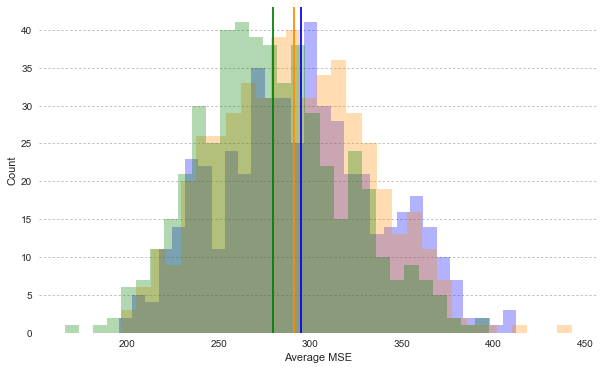

In [27]:
mse_score_lists = [gdbr0_mse_scores, gdbr1_mse_scores, gdbr2_mse_scores]
colors=['blue', 'darkorange', 'green']
pred.plot_mse_distribution(mse_score_lists,colors)

### Model Evaluation
The above histogram now shows the bootstrapped distributions of mean-squared error for:
1. GDBR0 (blue): Basic model with only location features 
2. GDBR1 (orange): Improved model with features that describe host quality
3. GDBR2 (green): Further improved model with features that describe listing age, special features (view and private bathroom), and property type (apartment, condo, house, etc) 

For each successive model, we've seen a notable reduction in average mean squared error!  The total improvement in terms of MSE is about 7.2%. 

Let's now use grid search to optimize our specific model on this feature space to see how much more improvement we get. 

## Grid Searching

To optimize our GradientBoostingRegressor, we will run a gridsearch on key parameters.

Some key parameters that have been shown to impact results from Gradient Boosting include:
1. learning_rate
2. max_features
3. min_samples_leaf
4. max_depth
5. n_estimators
6. subsample

In [28]:
grid_params = {'learning_rate': [ 0.001, 0.01], 
               'max_features': ['sqrt', 'log2', None],
               'min_samples_leaf': [1,2,4],
               'max_depth':[1,2,5],
               'n_estimators': [500, 1000, 2000, 4000],
               'subsample': [0.2, 0.5, 1.0]
              }

gdbr_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                               grid_params, n_jobs=-1, verbose=True)

# Perform grid search
gdbr_gridsearch.fit(X_train, y_train)
gdbr_gridsearch.best_estimator_

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  5.6min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [29]:
best_estimator_ = gdbr_gridsearch.best_estimator_

Optimal point: 2975 trees, MSE 261.645737745


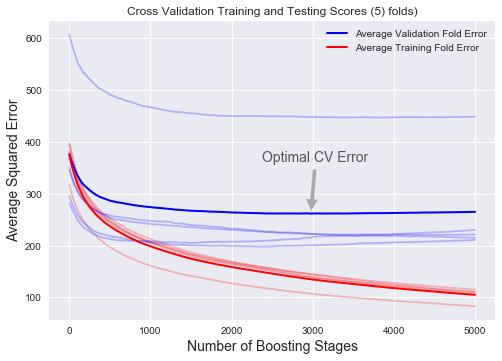

In [30]:
optimal_n_trees, learning_rate =  pred.plot_cross_validation_train_and_test(best_estimator_ ,
                                                                            X_train, y_train,N_ESTIMATORS = 5000)

Run gridsearch within bootstrap loop

In [31]:
gdbr2_gridsearch_mse_scores = pred.get_bootstrap_mse_score_dist(best_estimator_.set_params(n_estimators=optimal_n_trees), 
                                                                X, y, num_bootstrap=500)

Running iteration 0 ...
Running iteration 100 ...
Mean of mse_scores =  275.705373269
Running iteration 200 ...
Mean of mse_scores =  274.023374342
Running iteration 300 ...
Mean of mse_scores =  274.900339897
Running iteration 400 ...
Mean of mse_scores =  274.818665594
Mean MSE: 272.919609561


0 MSE: 294.825463778
1 MSE: 279.448125899
2 MSE: 272.919609561


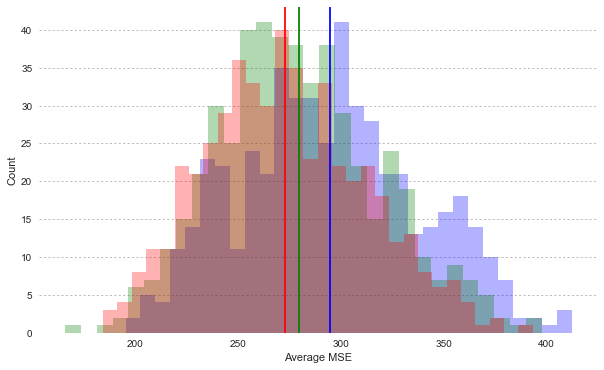

In [32]:
mse_score_lists = [gdbr0_mse_scores, gdbr2_mse_scores, gdbr2_gridsearch_mse_scores]
colors=['blue','green', 'red']
pred.plot_mse_distribution(mse_score_lists,colors)

### Model Evaluation
For simplicity, only results for iterations GDBR0, GDBR2 and the above gridsearch are shown above. 

Gridsearching gives us an additional incremental improvement in performance from GDBR2, which we'll happily take. 

Overall, we've managed to improve the model 7.5% (based on MSE).  

## Model Interpretation

Thankfully, Gradient Boosting provides a feature importance metric that allows for some interepretability.  While not as interpretable as the coefficients from linear regression, these feature importances provide some insight into the feature contributions to predictive power. 

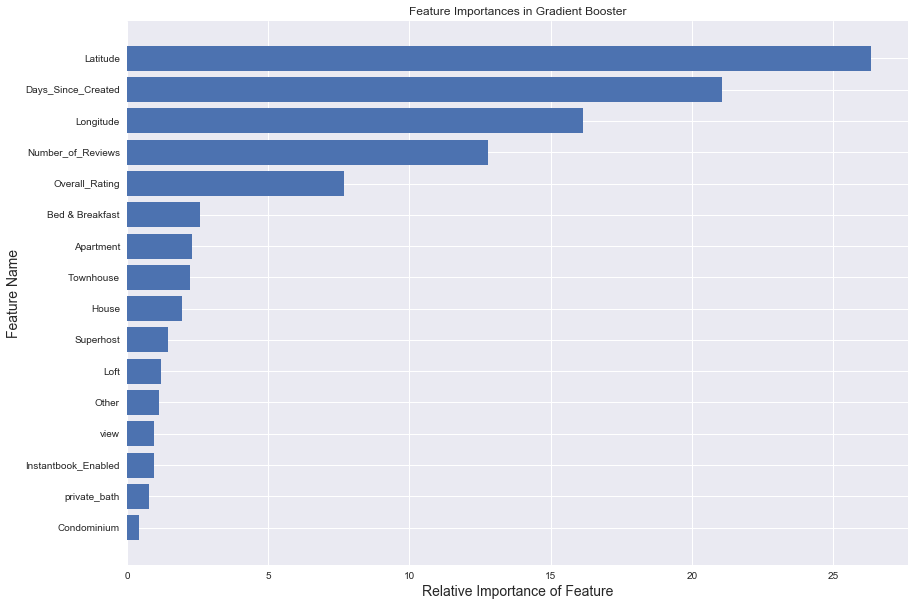

In [33]:
pred.plot_feature_importances(best_estimator_, X_train)

#### Observations:
Unsurprisingly, the location-based features, latitude and longitude, rank near the top of feature importance. The age of the listing (Days_Since_Created), review count (Number_of_Reviews), and overall rating (Overall_rating) round out the top 5 feature importances. 

These results align with intuition, as one would expect that an older listing with a lot of reviews and high rating will attract more airbnb visitors than a newer, "unproven" property.  That being said, there is strong multicollinearity among those features, since an older listing will naturally have had the time to aggregate more reviews.  Also, it is reasonable to expect that location and overall rating are also correlated, as location plays a huge role in the experience of an airbnb visitor. 

The other features have a modest contribution to feature importance, but given the improvements in average MSE score from our bootstrapping evaluation, we will keep them in the model. 

### Partial Dependency Plots

Partial dependency plots also add a level of interpretability by showing the relationship between feature importance and a given feature, given that all other features are set to their mean values.  

Each plot below demonstrates the change in feature importance, holding all other features in the model constant at their mean values. 

Here, the non-linear relationships between expected daily rate and lat-long are evident.  

It's worth noting the strong relationship with overall rating.  It appears ratings do indeed matter when it comes to pricing a room on airbnb. 

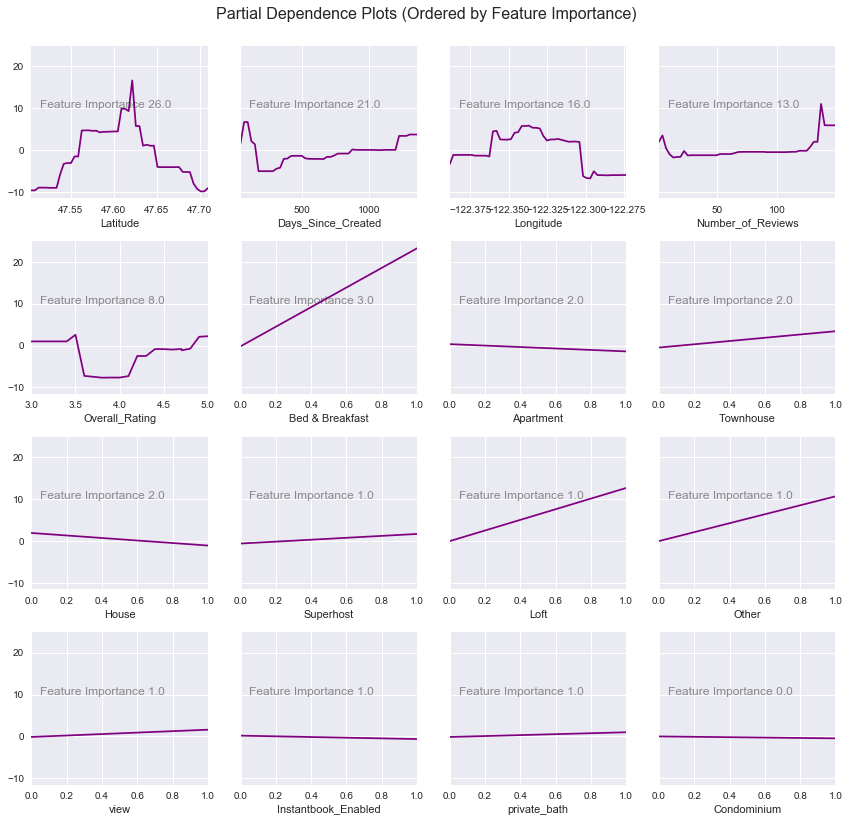

In [34]:
pred.plot_partial_dependency_plots(best_estimator_,X_train, 4,4,10)

## Summary

This brief walkthrough demonstrates the process of creating a predictive model to estimate the expected daily income from a room rented out on Airbnb. 

A brief summary of the steps taken:
1. Explore data
2. Conduct feature engineering
3. Select and optimize model
4. Evaluate model
5. Interpret results

Overall, our incremental efforts in feature engineering and model optimization yielded meaningful improvements in model performance. 

# Next steps
This model was trained on data from the Seattle area.  The model should be modified and then tested for other major metropolitan areas to assess the robustness of the model across different regions. 

Going forward, continued rigorous feature engineering will be a key part of improving the model performance, especially as additional data and experience is gathered.  